In [2]:
import os
import time
import random
import torch
import mrcfile
import tifffile
import numpy as np
from torch import nn
from math import ceil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch import FloatTensor as FT
from torch.autograd import Variable as V
from concurrent.futures import ThreadPoolExecutor

from matplotlib.colors import ListedColormap
rawData = "/home/tyche/paddle_SN2N/raw_data/"
Datasets = "/home/tyche/paddle_SN2N/datasets/"


def get_all_files(directory):
    file_list = list()
    n_files = 0
    for file in os.listdir(directory):
        file_list.append(f"{directory}/{file}")
        n_files += 1
    return file_list, n_files


import torch
print(torch.__version__)
print(torch.version.cuda)

2.7.0+cu126
12.6


In [3]:
def split_by_index(arr):
    groups = {}
    for row in arr:
        key = row[0]
        if key not in groups:
            groups[key] = []
        groups[key].append(row)
    
    # 转换为NumPy数组
    for key in groups:
        groups[key] = np.array(groups[key])
    
    return groups
arr = np.array([
    [1, 2, 3],
    [1, 4, 5],
    [2, 6, 7],
    [2, 8, 9],
    [3, 10, 11]
])

# 示例
groups_dict = split_by_index(arr)
for key, group in groups_dict.items():
    print(f"index {key}:")
    print(group)
    print()

def get_map_from_predictions():
    # chunk_files = [os.path.join('./predictions', f) for f in os.listdir('./predictions') if f.endswith('.npz')]
    chunk_files = [os.path.join('./datasets', f) for f in os.listdir('./datasets') if f.endswith('.npz')]
    chunk_positions = [os.path.splitext(os.path.basename(f))[0].split("_") for f in chunk_files]
    chunk_positions = np.array(chunk_positions, dtype=int)
    groups = split_by_index(chunk_positions)

    
    # for chunk_file, chunk_position in zip(chunk_files, chunk_positions):
     
    




index 1:
[[1 2 3]
 [1 4 5]]

index 2:
[[2 6 7]
 [2 8 9]]

index 3:
[[ 3 10 11]]



In [4]:
kernel = torch.tensor([[[[0, 1], [1, 1]], [[1, 1], [1, 1]]],
                       [[[1, 0], [1, 1]], [[1, 1], [1, 1]]],
                       [[[1, 1], [0, 1]], [[1, 1], [1, 1]]],
                       [[[1, 1], [1, 0]], [[1, 1], [1, 1]]],
                       [[[1, 1], [1, 1]], [[0, 1], [1, 1]]],
                       [[[1, 1], [1, 1]], [[1, 0], [1, 1]]],
                       [[[1, 1], [1, 1]], [[1, 1], [0, 1]]],
                       [[[1, 1], [1, 1]], [[1, 1], [1, 0]]],])
kernel = torch.tensor([[[[1, 0], [0, 1]], [[0, 1], [1, 0]]],  
                       [[[0, 1], [1, 0]], [[1, 0], [0, 1]]]]).float()
kernel = torch.tensor([[[[1, 0], [0, 1]], [[0, 1], [1, 0]]], 
                       [[[0, 1], [1, 0]], [[1, 0], [0, 1]]]])

kernel.shape

torch.Size([2, 2, 2, 2])

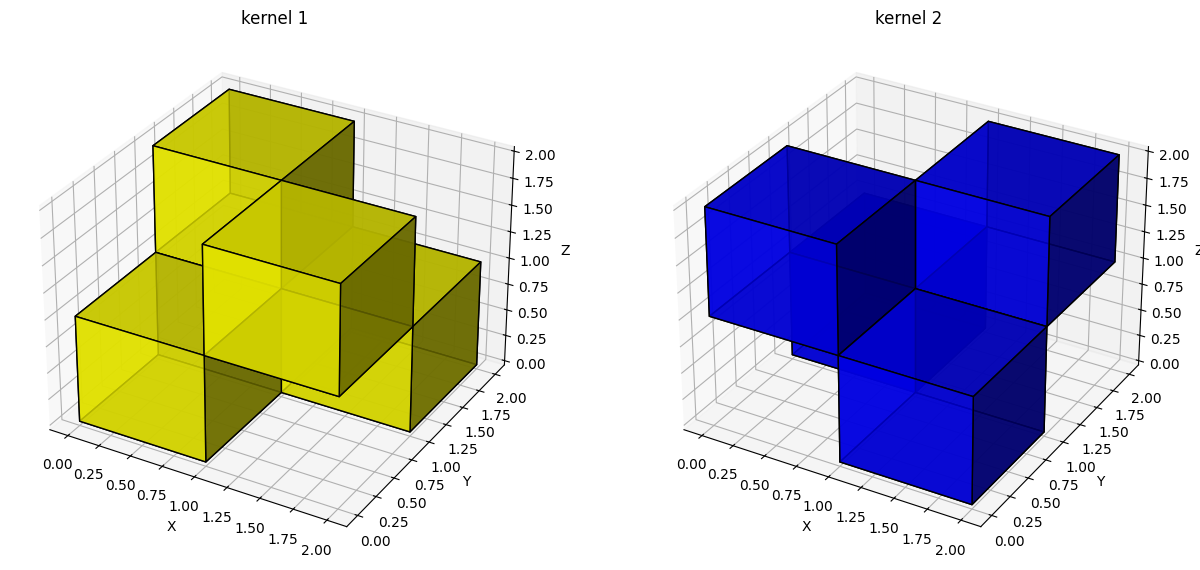

In [5]:
data = np.random.choice([0, 1], size=(5, 5, 5))
colors = ['yellow', 'blue', 'green', 'red', 'purple']
cmap = ListedColormap(colors)
fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw={'projection': '3d'})
axes = axes.flatten()
for i in range(min(8, kernel.shape[0])):  # 最多显示6个子图
    ax = axes[i]
    ax.voxels(kernel[i], facecolors=cmap(i%len(colors)), edgecolor='k', alpha=0.8)
    ax.set_title(f'kernel {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
plt.show()

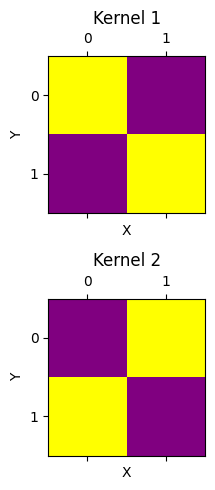

In [6]:
kernel = torch.tensor([[[1, 0], [0, 1]],
                      [[0, 1], [1, 0]]]).float() / 2
colors = ['yellow', 'blue', 'green', 'red', 'purple']
cmap = ListedColormap(colors[::-1])
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes = axes.flatten()

# 可视化每个卷积核
for i in range(kernel.shape[0]):
    ax = axes[i]
    # 使用matshow可视化2D卷积核
    im = ax.matshow(kernel[i], cmap=cmap)
    ax.set_title(f'Kernel {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
plt.tight_layout()
plt.show()


In [7]:
conv_layer = torch.nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=2, stride=2, padding=0, bias=False)
conv_layer.weight.data = kernel
batch_chunks = conv_layer(batch_chunks)

NameError: name 'out_channels' is not defined

In [ ]:
x = torch.arange(8).view(2, 2, 2)
dims = [[0, 1], [1, 2], [0, 2]]
fig, axes = plt.subplots(1, 4, figsize=(15, 10), subplot_kw={'projection': '3d'})
axes = axes.flatten()
for i in range(3):  
    ax = axes[i]
    ax.voxels(torch.rot90(x, 1, dims[i]), facecolors=cmap(i%len(colors)), edgecolor='k', alpha=0.8)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
axes[3].voxels(x)
plt.show()
torch.rot90(x, 1, [0, 2])


In [ ]:
import imageio

def combine_tensors_to_gif(
    tensors,
    titles,
    output_path: str = "combined_tensors.gif",
    fps: int = 2,
    cmap: str = "viridis",
    figsize: tuple = (12, 8),
    dpi: int = 100,
    show_colorbar: bool = True,
    vmin = 0,
    vmax = 255
):

    # Check all tensors have the same depth
    depths = [tensor.shape[0] for tensor in tensors]
    depth = max(depths)
    
    # Create output directory if it doesn't exist
    output_dir = os.path.dirname(output_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Generate frames for GIF
    frames = []
    
    for i in range(depth):
        # Create figure and axes
        fig, axes = plt.subplots(1, len(tensors), figsize=figsize, dpi=dpi, sharey=True)
        if len(tensors) == 1:
            axes = [axes]  # Ensure axes is always a list
        
        # Plot each tensor's current layer
        ims = []
        for j, tensor in enumerate(tensors):
            im = axes[j].imshow(tensor[i, :, :], cmap=cmap, vmin=vmin, vmax=vmax)
            ims.append(im)
            axes[j].set_title(f"{titles[j]}_Layer_{i}")
        
        # Add colorbar if specified
        if show_colorbar:
            fig.subplots_adjust(right=0.9)
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            fig.colorbar(ims[0], cax=cbar_ax)
        
        # Render figure to numpy array
        plt.tight_layout()
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        
        # Close figure to free memory
        plt.close(fig)
    
    # Save frames as GIF
    imageio.mimsave(output_path, frames, fps=fps, loop=0)
    print(f"GIF saved to: {output_path}")

# Example usage
if __name__ == "__main__":
    # Create sample 3D tensors
    tensor1 = np.random.rand(10, 50, 50)  # 10 layers, 50x50 each
    tensor2 = np.random.rand(10, 50, 50)  # 10 layers, 50x50 each
    
    # Add structure to tensors for better visualization
    for i in range(10):
        x, y = np.ogrid[-i:50-i, -i:50-i]
        mask = x*x + y*y <= (25-i)**2
        tensor1[i][mask] = 2 * tensor1[i][mask]
        tensor2[i][mask] = 3 * tensor2[i][mask]
    
    # Create a sphere tensor
    sphere = np.zeros((10, 50, 50))
    for z in range(10):
        for y in range(50):
            for x in range(50):
                if (x-25)**2 + (y-25)**2 + (z-4)**2 <= 40:
                    sphere[z, y, x] = 1.0
    
    # Save all tensors to a single GIF
    combine_tensors_to_gif(
        tensors=[tensor1,
            tensor2,
            sphere],
        titles=['t1', 't2', 't3'],
        output_path="combined_tensors.gif",
        fps=24,
        cmap="viridis"
    )   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from typing import Dict, Optional
import os

def combine_tensors_to_gif(
    tensors: Dict[str, np.ndarray],
    output_path: str = "combined_tensors.gif",
    fps: int = 2,
    cmap: str = "viridis",
    figsize: tuple = (12, 8),
    dpi: int = 100,
    show_colorbar: bool = True,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None
) -> None:

    # Check all tensors have the same depth
    depths = [tensor.shape[0] for tensor in tensors.values()]   
    depth = max(depths)
    
    # Create output directory if it doesn't exist
    output_dir = os.path.dirname(output_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Generate frames for GIF
    frames = []
    
    for i in range(depth):
        # Create figure and axes
        fig, axes = plt.subplots(1, len(tensors), figsize=figsize, dpi=dpi, sharey=True)
        if len(tensors) == 1:
            axes = [axes]  # Ensure axes is always a list
        
        # Plot each tensor's current layer
        ims = []
        for j, (name, tensor) in enumerate(tensors.items()):
            im = axes[j].imshow(tensor[i % tensor.shape[0]], cmap=cmap, vmin=vmin, vmax=vmax)
            ims.append(im)
            axes[j].set_title(f"{name} - Layer {i % tensor.shape[0]}")
        
        # Add colorbar if specified
        if show_colorbar:
            fig.subplots_adjust(right=0.9)
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            fig.colorbar(ims[0], cax=cbar_ax)
        
        # Render figure to numpy array
        plt.tight_layout()
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        
        # Close figure to free memory
        plt.close(fig)
    
    # Save frames as GIF
    imageio.mimsave(output_path, frames, fps=fps, loop=0)
    print(f"GIF saved to: {output_path}")

# Example usage
if __name__ == "__main__":
    tensor1 = np.asarray(tifffile.imread('c12_SR_w1L-561_t1.tif'))
    maximum = np.percentile(tensor1[tensor1 > 0], 99.999)
    tensor1 = tensor1.clip(min=0.0, max=maximum) / maximum
    tensor2 = np.asarray(tifffile.imread('c12_SR_w1L-561_t1.tif'))
    maximum = np.percentile(tensor2[tensor2 > 0], 99.999)
    tensor2 = tensor2.clip(min=0.0, max=maximum) / maximum
    combine_tensors_to_gif(
        tensors={
            "Tensor 1": tensor1,
            "Tensor 2": tensor2,
        },
        output_path="combined_tensors.gif",
        fps=24,
        cmap="viridis"
    )    

In [ ]:
axes_options = random.choice([(0, 1), (1, 2), (0, 2)])
axes_options

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft


# 定义卷积核
kernel1 = np.array([[1, 0], [0, 1]])
kernel2 = np.array([[0, 1], [1, 0]])

# 扩展卷积核到更大的尺寸以便进行傅里叶变换
def pad_kernel(kernel, size=64):
    padded = np.zeros((size, size))
    h, w = kernel.shape
    padded[:h, :w] = kernel
    return padded

# 计算频域响应
def compute_frequency_response(kernel):
    # padded = pad_kernel(kernel)
    freq_response = fft.fft2(kernel)
    freq_response = fft.fftshift(freq_response)
    magnitude = np.abs(freq_response)
    phase = np.angle(freq_response)
    return magnitude, phase

# 计算两个卷积核的频域响应
mag1, phase1 = compute_frequency_response(kernel1)
mag2, phase2 = compute_frequency_response(kernel2)

# 可视化
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 显示卷积核
im00 = axes[0, 0].imshow(kernel1, cmap='gray')
axes[0, 0].set_title('[[1, 0], [0, 1]]')
axes[0, 0].axis('off')
fig.colorbar(im00, ax=axes[0, 0])  # 添加色条

im10 = axes[1, 0].imshow(kernel2, cmap='gray')
axes[1, 0].set_title('[[0, 1], [1, 0]]')
axes[1, 0].axis('off')
fig.colorbar(im10, ax=axes[1, 0])  # 添加色条

# 显示幅度响应
im01 = axes[0, 1].imshow(np.log(mag1 + 1), cmap='viridis')
axes[0, 1].set_title('magnitude (log)')
axes[0, 1].axis('off')
fig.colorbar(im01, ax=axes[0, 1])  # 添加色条

im11 = axes[1, 1].imshow(np.log(mag2 + 1), cmap='viridis')
axes[1, 1].set_title('magnitude (log)')
axes[1, 1].axis('off')
fig.colorbar(im11, ax=axes[1, 1])  # 添加色条

# 显示相位响应
im02 = axes[0, 2].imshow(phase1, cmap='hsv')
axes[0, 2].set_title('phase')
axes[0, 2].axis('off')
fig.colorbar(im02, ax=axes[0, 2])  # 添加色条

im12 = axes[1, 2].imshow(phase2, cmap='hsv')
axes[1, 2].set_title('phase')
axes[1, 2].axis('off')
fig.colorbar(im12, ax=axes[1, 2])  # 添加色条

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.fft as fft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 这里是你提供的函数
def fourier_interpolate(tensor, scale_factor=2):
    assert tensor.ndim == 5, "[B, C, D, H, W]"
    
    # 3D FFT
    tensor_fft = fft.rfftn(tensor, dim=(-3, -2, -1))
    batch_size, channels, d, h, w = tensor.shape
    
    new_d = d * scale_factor
    new_h = h * scale_factor
    new_w = w * scale_factor
    
    tensor_fft_padded = torch.zeros(
        (batch_size, channels, new_d, new_h, new_w),
        dtype=tensor_fft.dtype,
        device=tensor_fft.device
    )
    d_start = (new_d - d) // 2
    h_start = (new_h - h) // 2
    w_start = (new_w - w) // 2 
    
    tensor_fft_padded[
        :, :, 
        d_start:d_start+d, 
        h_start:h_start+h, 
        w_start:w_start+w] = tensor_fft
    
    tensor_interpolated = fft.irfftn(tensor_fft_padded, s=(new_d, new_h, new_w), dim=(-3, -2, -1))
    
    tensor_interpolated = tensor_interpolated * (scale_factor ** 3)
    return tensor_interpolated

# 创建一个简单的三维测试数据
def create_test_volume(size=(8, 8, 8)):
    d, h, w = size
    volume = torch.zeros(1, 1, d, h, w)
    
    # 在体数据中创建一些简单的结构
    # 中心球体
    center = (d//2, h//2, w//2)
    radius = min(d, h, w) // 4
    
    for z in range(d):
        for y in range(h):
            for x in range(w):
                dist = np.sqrt((z-center[0])**2 + (y-center[1])**2 + (x-center[2])**2)
                if dist < radius:
                    volume[0, 0, z, y, x] = 1.0
    
    # 添加一些额外的结构
    volume[0, 0, d//4, h//4:3*h//4, w//4:3*w//4] = 0.7
    volume[0, 0, 3*d//4, h//4:3*h//4, w//4:3*w//4] = 0.7
    
    return volume

# 可视化原始和插值后的体数据
def visualize_volume(volume, title="Volume Data"):
    # 只可视化一个通道的中心切片
    volume = volume[0, 0].cpu().numpy()
    d, h, w = volume.shape
    
    # 创建一个2x2的子图
    fig = plt.figure(figsize=(12, 10))
    
    # 中间深度切片
    ax1 = fig.add_subplot(221)
    ax1.imshow(volume[d//2], cmap='viridis')
    ax1.set_title(f'Depth slice {d//2}')
    
    # 中间高度切片
    ax2 = fig.add_subplot(222)
    ax2.imshow(volume[:, h//2, :], cmap='viridis')
    ax2.set_title(f'Height slice {h//2}')
    
    # 中间宽度切片
    ax3 = fig.add_subplot(223)
    ax3.imshow(volume[:, :, w//2], cmap='viridis')
    ax3.set_title(f'Width slice {w//2}')
    
    # 3D体渲染（简化版，只显示值大于阈值的点）
    ax4 = fig.add_subplot(224, projection='3d')
    threshold = 0.1
    z, y, x = np.where(volume > threshold)
    values = volume[volume > threshold]
    scatter = ax4.scatter(x, y, z, c=values, cmap='viridis', alpha=0.6)
    ax4.set_title('3D Volume Rendering')
    plt.colorbar(scatter, ax=ax4)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# 主函数：创建数据、插值并可视化
def main():
    # 创建原始体数据
    original_volume = create_test_volume(size=(16, 16, 16))
    print(f"原始体数据形状: {original_volume.shape}")
    
    # 可视化原始数据
    visualize_volume(original_volume, "原始体数据")
    
    # 应用傅里叶插值，放大2倍
    scale_factor = 2
    interpolated_volume = fourier_interpolate(original_volume, scale_factor=scale_factor)
    print(f"插值后体数据形状: {interpolated_volume.shape}")
    
    # 可视化插值后的数据
    visualize_volume(interpolated_volume, f"傅里叶插值 (x{scale_factor})")

if __name__ == "__main__":
    main()


In [ ]:
from datetime import datetime


local_now = datetime.now()
print(local_now)  # 输出: 2023-10-09 16:30:00.123456

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def log_line_generator(file_path):
    """生成器：逐行返回日志内容，避免一次性加载"""
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            yield line

def visualize_training(log_file, title="Training Process Visualization", save_path=None, figsize=(15, 10)):
    """
    Visualize multiple metrics during training: batch loss, epoch average loss, validation loss, and learning rate
    
    Args:
        log_data (str): String containing training logs
        title (str): Chart title
        save_path (str, optional): Path to save the chart. If None, display the chart.
        figsize (tuple): Chart size in format (width, height)
    """

    # Extract batch loss data
    batch_loss_pattern = r'\[processing: (\d+)/\d+\] \[loss: ([\d.]+)\]'
    batch_matches = re.findall(batch_loss_pattern, log_data)
    batch_indices = [int(match[0]) for match in batch_matches]
    batch_losses = [float(match[1]) for match in batch_matches]
    
    # Extract epoch data (assuming validation loss is recorded at the end of each epoch)
    epoch_pattern = r'\[epoch: (\d+)\].*?\[val_loss: ([\d.]+)\]'
    epoch_matches = re.findall(epoch_pattern, log_data)
    epochs = [int(match[0]) for match in epoch_matches]
    val_losses = [float(match[1]) for match in epoch_matches]
    
    # Extract learning rate data
    lr_pattern = r'\[lr: ([\d.e-]+)\]'
    lr_matches = re.findall(lr_pattern, log_data)
    lrs = [float(match) for match in lr_matches]
    
    # Calculate average training loss per epoch
    epoch_avg_losses = []
    if epochs and batch_indices:
        samples_per_epoch = max(batch_indices)
        for epoch in epochs:
            start_idx = (epoch - 1) * samples_per_epoch
            end_idx = epoch * samples_per_epoch
            epoch_losses = batch_losses[start_idx:end_idx]
            if epoch_losses:
                epoch_avg_losses.append(np.mean(epoch_losses))
    
    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=False)
    fig.suptitle(title, fontsize=16)
    
    # Plot batch loss and epoch average loss
    ax1.plot(batch_indices, batch_losses, 'b-', alpha=0.3, linewidth=1, label='Batch Loss')
    if epoch_avg_losses:
        ax1.plot(epochs, epoch_avg_losses, 'g-', linewidth=2, marker='o', label='Epoch Average Loss')
    if val_losses:
        ax1.plot(epochs, val_losses, 'r-', linewidth=2, marker='s', label='Validation Loss')
    
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.set_ylabel('Loss Value', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=10)
    ax1.set_xlim(1, max(batch_indices) if batch_indices else 1)
    ax1.set_ylim(0, max(batch_losses + epoch_avg_losses + val_losses) * 1.1 if batch_losses else 1)
    
    # Plot learning rate changes
    ax2.plot(batch_indices, lrs, 'm-', linewidth=2)
    ax2.set_title('Learning Rate Schedule', fontsize=14)
    ax2.set_xlabel('Training Steps', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_xlim(1, max(batch_indices) if batch_indices else 1)
    ax2.set_yscale('log')  # Use logarithmic scale for better visualization of LR changes
    
    # Ensure x-axis only shows integers
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
    
    # Save or display the chart
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Chart saved to: {save_path}")
    else:
        plt.show()
    
    return fig, (ax1, ax2)

# Example usage
if __name__ == "__main__":
    # Sample log data (including training loss, validation loss, and learning rate)
    
    # Visualize training process
    visualize_training(log_data, title="Model Training Process Visualization")    

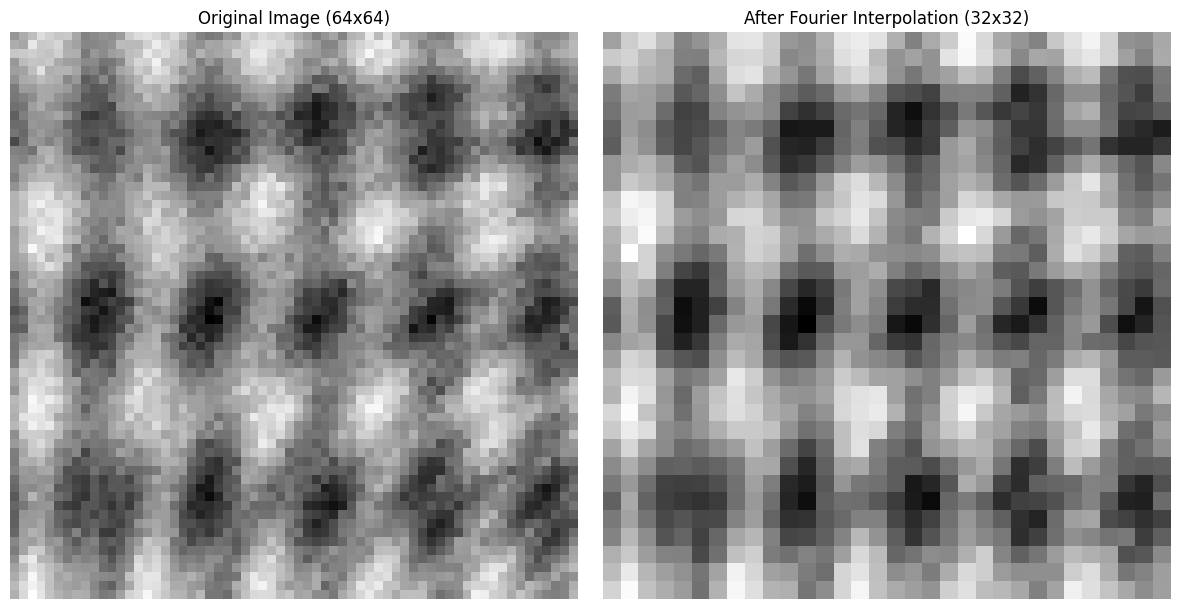

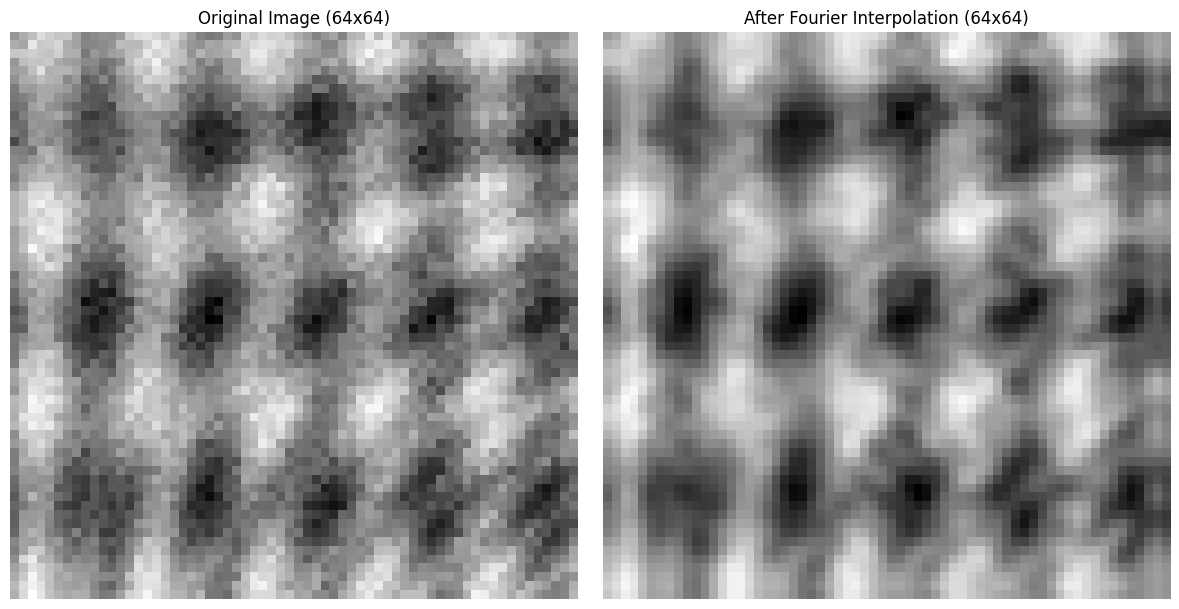

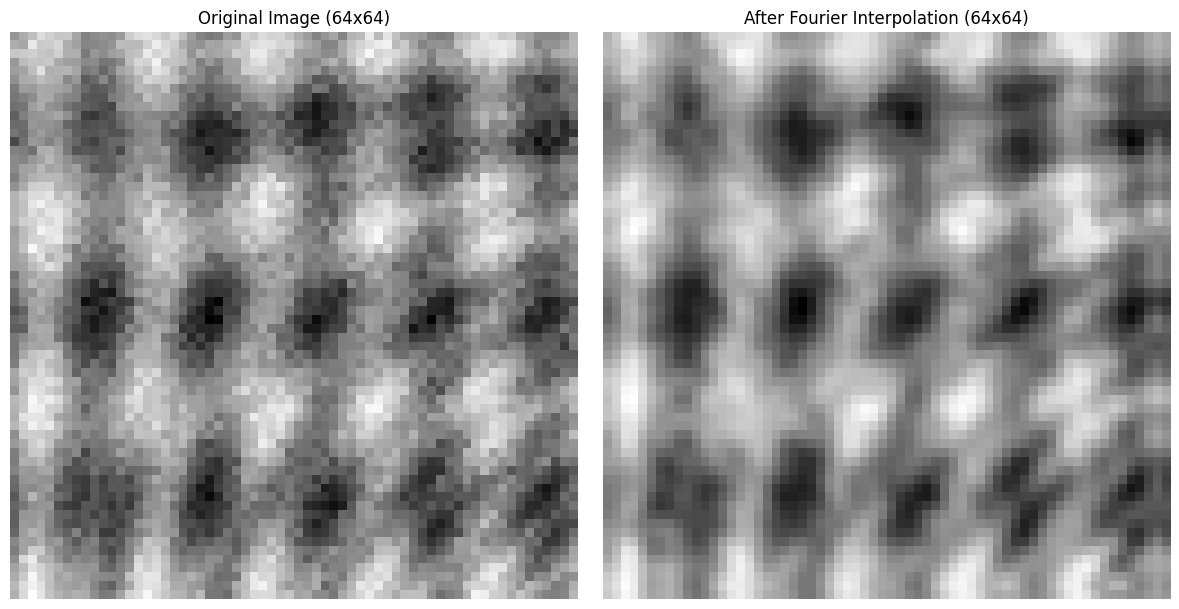

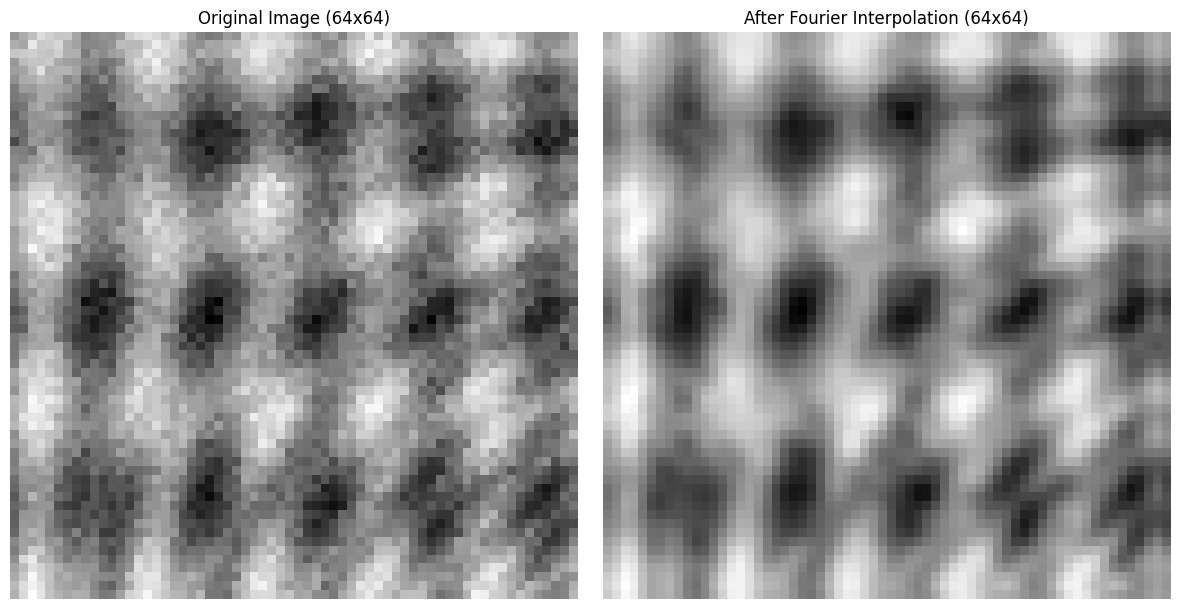

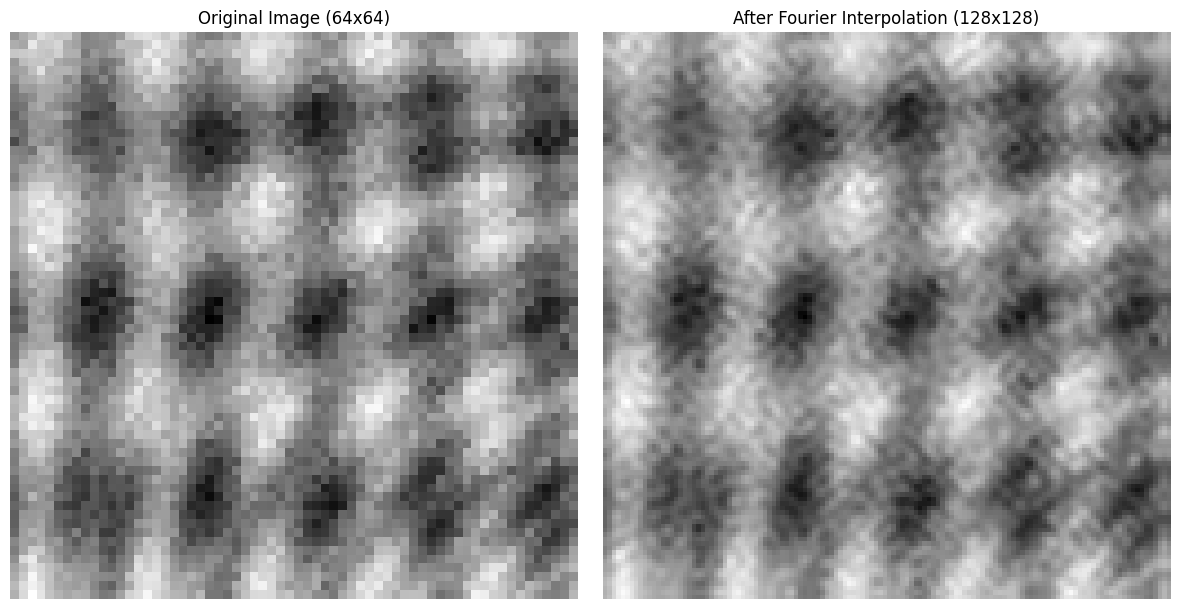

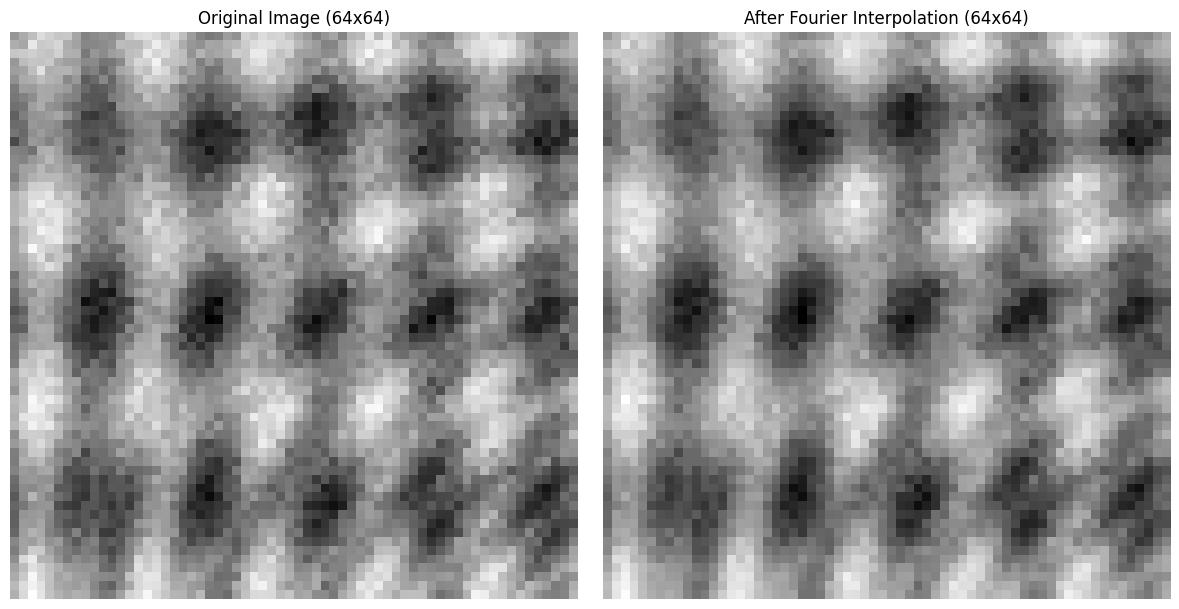

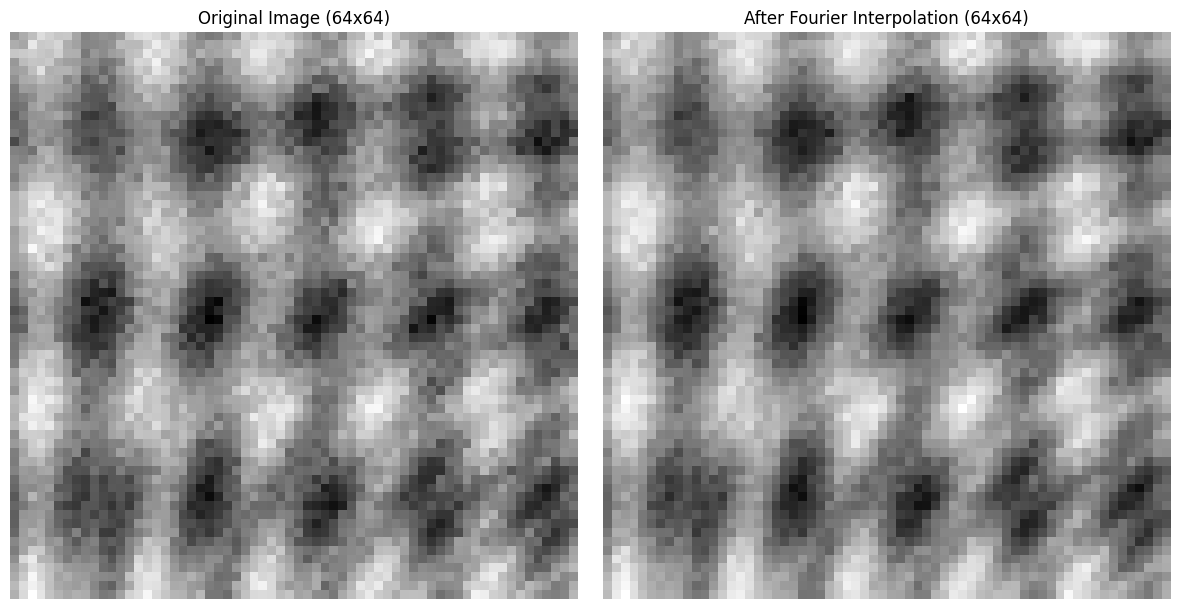

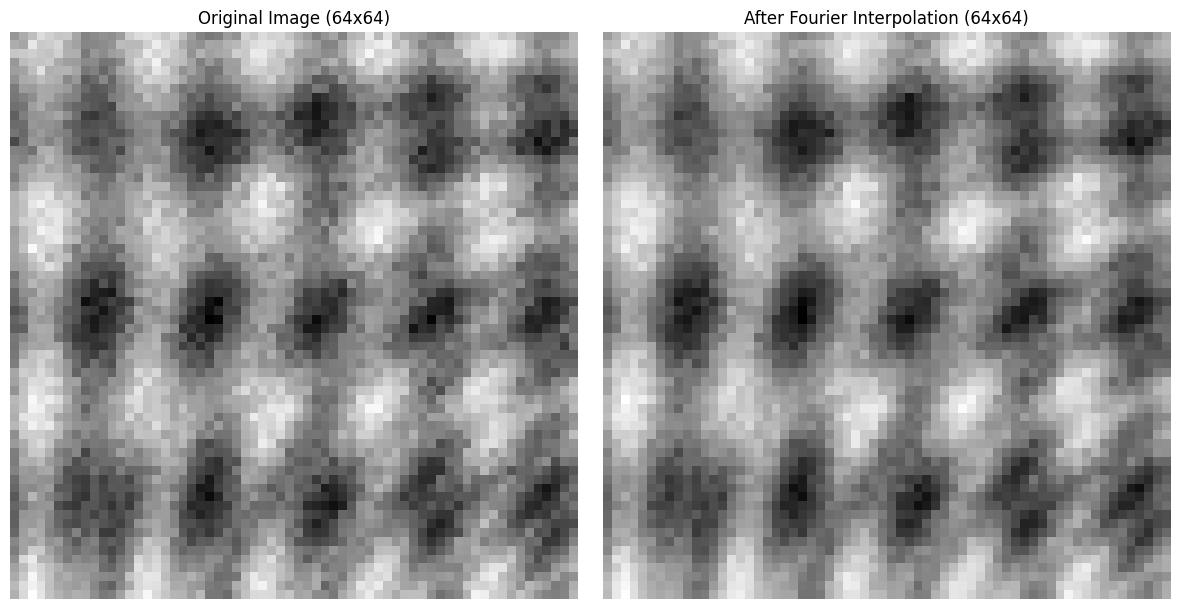

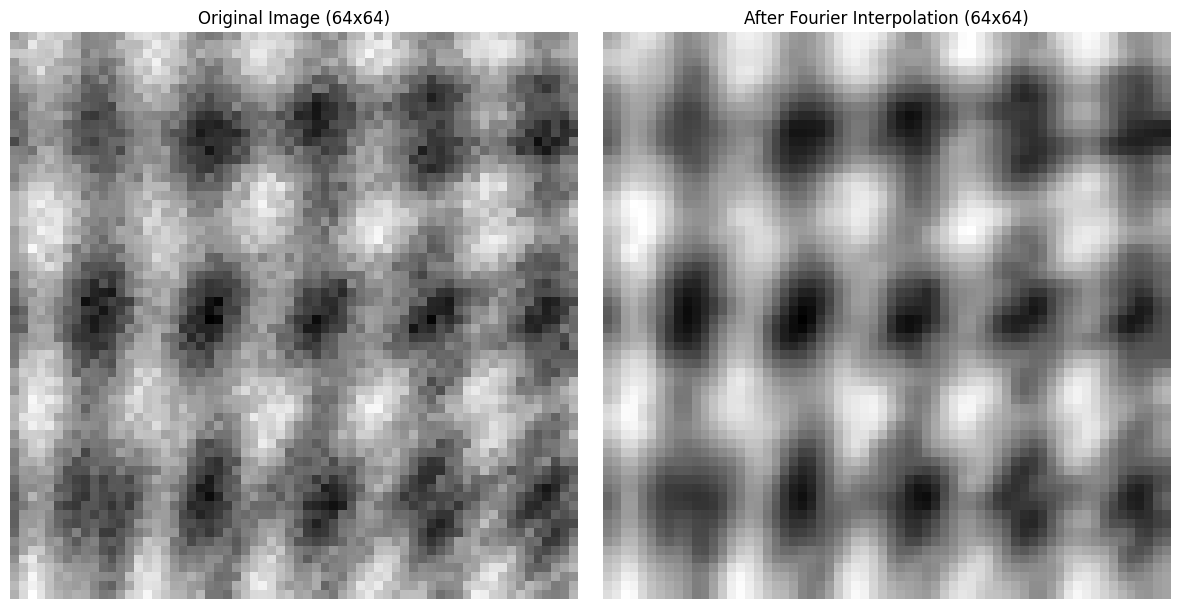

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.utils.utils_dataprocessing import fourier_interpolate


def create_test_image(size: int = 64) -> torch.Tensor:
    """Create a test image for demonstration of interpolation effects"""
    # Create grid
    x = np.linspace(0, 1, size)
    y = np.linspace(0, 1, size)
    xx, yy = np.meshgrid(x, y)
    
    # Create a test image with various frequency components
    img = np.sin(2 * np.pi * 5 * xx) + np.cos(2 * np.pi * 3 * yy)
    img += 0.5 * np.sin(2 * np.pi * 10 * xx * yy)
    img += 0.3 * np.random.randn(size, size)  # Add some noise
    
    # Normalize to [0, 1]
    img = (img - img.min()) / (img.max() - img.min())
    
    return torch.tensor(img, dtype=torch.float32)

def visualize_results(original: torch.Tensor, upsampled: torch.Tensor):
    """Visualize the original and upsampled images"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display original image
    axes[0].imshow(original.numpy(), cmap='gray')
    axes[0].set_title(f'Original Image ({original.shape[0]}x{original.shape[1]})')
    axes[0].axis('off')
    
    # Display upsampled image
    axes[1].imshow(upsampled.numpy(), cmap='gray')
    axes[1].set_title(f'After Fourier Interpolation ({upsampled.shape[0]}x{upsampled.shape[1]})')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Create test image
    test_image = create_test_image(size=64)


    kernel = torch.tensor([[[1, 0], [0, 1]], 
                           [[0, 1], [1, 0]]], requires_grad=False).float() / 2

    out_channels, *spatial_dims = kernel.shape
    kernel = kernel.view(out_channels, 1, *spatial_dims)
    chunks_shape = test_image.shape
    batch_chunks = test_image.view(-1, 1, *chunks_shape)
    upsampled_image1 = fourier_interpolate(batch_chunks)
    conv_layer = torch.nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=2, stride=2, padding=0, bias=False)
    conv_layer.weight.data = kernel
    batch_chunks = conv_layer(batch_chunks)
    visualize_results(test_image, batch_chunks[0][0].detach())
    bilinear_image = torch.nn.functional.interpolate(batch_chunks[0][0].detach().view(-1, 1, *batch_chunks[0][0].shape), scale_factor=2, mode='bilinear')
    upsampled_image = fourier_interpolate(batch_chunks)
    visualize_results(test_image, upsampled_image[0][0].detach())
    visualize_results(test_image, upsampled_image[0][1].detach())
    visualize_results(test_image, upsampled_image[0][1].detach()/2 + upsampled_image[0][0].detach()/2)
    visualize_results(test_image, upsampled_image1[0][0].detach())
    visualize_results(test_image, conv_layer(upsampled_image1)[0][0].detach())
    visualize_results(test_image, conv_layer(upsampled_image1)[0][1].detach())
    visualize_results(test_image, conv_layer(upsampled_image1)[0][1].detach() / 2 + conv_layer(upsampled_image1)[0][0].detach() / 2)
    visualize_results(test_image, bilinear_image[0][0])

In [ ]:
import torch


In [9]:
X = torch.rand(size=(10, 10, 10, 10, 10))

print(X.shape)
i_indices, j_indices = torch.triu_indices(10, 10, offset=1)
print(i_indices)
print(j_indices)

torch.Size([10, 10, 10, 10, 10])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9,
        4, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9])
